# Lesson 10 - Dimensions and visualisation

> Introduction to dimensionality reduction and visualisation.

In this lecture we will have a look at dimension reduction and data visualisation. When we look at the feature vector of a dataset it can contain many features and each feature corresponds to its own dimension. In the first part of the notebook we will explore a method to reduce the dimensionality of a dataset. In the second part we will look at a an algorithm to extract information from high-dimensional data and display it's structure in two dimensions. Both these methods fall into the cateogory of unsupersvised algorithms.

## Part 1: Principal component analysis

First we have a look at a method to reduce the dimensions of a dataset. There are two main reasons why we would like to reduce the dimensionality of such datasets:

1. Some machine learning algorithms struggle with high dimensional data.
2. It is hard to visualize high dimensional data. In practice it is hard to visualise datasets that have more than two or three dimensions.

There is one very common approach to reduce the dimensionality of data: the principal component analysis (PCA). The idea is that not all axis contain the same amount of variance and that ther are even combination of axis that contain most variance. PCA seeks to find new coordinate axis such that the variance along the axis is maximised and ordered (the first principal component conatains most variance).

In [ ]:
# dalineplotrangling
import pandas as pd
import numpy as np
from dslectures.core import get_dataset, convert_strings_to_categories, rmse, fill_missing_values_with_median
from pathlib import Path
from tqdm import tqdm

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

#dslecture
from dslectures.core import rmse

### Load the data
We will use the processed housing dataset for the principal component analysis. First we have to load it.

In [ ]:
get_dataset('housing_processed.csv')

Dataset already exists at '../data/housing_processed.csv' and is not downloaded again.


In [ ]:
data_path = Path('../data/')

In [ ]:
housing_data = pd.read_csv(data_path/'housing_processed.csv')

In [ ]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,city,postal_code,rooms_per_household,bedrooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,69,94705,6.984127,1.023810,0.146591,2.555556,0,0,1,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,620,94611,6.238137,0.971880,0.155797,2.109842,0,0,1,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,620,94618,8.288136,1.073446,0.129516,2.802260,0,0,1,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,620,94618,5.817352,1.073059,0.184458,2.547945,0,0,1,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,620,94618,6.281853,1.081081,0.172096,2.181467,0,0,1,0,0


In [ ]:
housing_data.shape

(19443, 20)

In [ ]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,city,postal_code,rooms_per_household,bedrooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND
count,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000,19443.000000
mean,-119.560363,35.646739,28.435118,2617.678548,538.136964,1442.129970,501.427352,3.675099,191793.406162,541.629224,93030.145605,5.340245,1.091741,0.214812,3.095953,0.331482,0.439953,0.106774,0.121535,0.000257
std,2.002697,2.145335,12.504584,2179.553070,420.168532,1140.254218,383.064222,1.569687,96775.724042,260.704512,1853.684352,2.190405,0.429728,0.056667,10.679036,0.470758,0.496394,0.308833,0.326756,0.016035
min,-124.350000,32.550000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.000000,85344.000000,0.846154,0.333333,0.100000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.760000,33.930000,18.000000,1438.500000,299.000000,799.000000,282.000000,2.526500,116700.000000,328.000000,91706.000000,4.412378,1.006140,0.177906,2.449692,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,29.000000,2111.000000,436.000000,1181.000000,411.000000,3.446400,173400.000000,545.000000,92860.000000,5.180451,1.048276,0.204545,2.841155,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-117.990000,37.730000,37.000000,3119.000000,644.000000,1746.500000,606.000000,4.579750,247100.000000,770.000000,94606.000000,5.963796,1.097701,0.240414,3.308208,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,499100.000000,977.000000,96161.000000,132.533333,34.066667,1.000000,1243.333333,1.000000,1.000000,1.000000,1.000000,1.000000


We drop the two columns that contain categorical data with many categories. We could create extra columns for each categoriy but since there are many of them that would create a lot of extra features.

In [ ]:
housing_data.drop(['city', 'postal_code'], axis=1, inplace=True)

Then we split the data into features and labels as usual:

In [ ]:
X = housing_data.drop('median_house_value', axis=1)
y = housing_data['median_house_value']
feature_labels = X.columns

#### Baseline
First we train the a Random Forest with the settings we tuned in lesson 6 as a baseline for future model.

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1, random_state=42)
                             
results = cross_validate(rf, X, y,
                         cv=5,
                         return_train_score=True,
                         scoring='neg_root_mean_squared_error')
rmse_full = -np.mean(results["test_score"])

We get an RMSE of roughly 60'000:

In [ ]:
print(f'RMSE: {rmse_full}')

RMSE: 60301.958010516806


### Standardisation
PCA works by finding new axis in the dataset that cover the most variance. Since variance is the average squared distance of each sample to the sample mean this depends on the scale of the feature. To illustrate this think of two columns that contain the height of the person measured in centimeter and meter. Although height described in these two columns are the same the variance will be 10'000 times larger in the centimeter column (100^2) and the standard deviation 100 times larger.

In [ ]:
rand_values = np.random.randn(1000)

In [ ]:
rand_values.var()

0.993002491123281

In [ ]:
(100*rand_values).var()

9930.024911232811

For this reason it is important to scale the features such that they are comparable to each other. A common approach to do this is to transform the data such that the mean is zero and the standard deviation is one. The following formula achieves this:

$x_{std}=\frac{x_{old}-\mu}{\sigma}$

Scikit-learn provides a function to do this for us called `StandardScaler`. We can do this in one line with the function `.fit_transform()`. Similar to the function `fit_predict()` it combines the process of fitting which means calculating the mean and standard deviation of the dataset and then transforming the data by applying the above described formula.

In [ ]:
X_std = StandardScaler().fit_transform(X)

In [ ]:
X_std.shape

(19443, 17)

We can see that the mean is zero (or close enough) and the standard deviation is one:

In [ ]:
X_std.mean(axis=0)

array([-4.44386137e-16,  2.19854194e-15,  9.35549763e-17, -2.48505406e-17,
       -1.02325755e-16,  7.74752147e-17, -1.24252703e-17, -1.46179650e-16,
       -9.94021623e-17,  1.57874022e-16,  7.01662322e-17,  2.92359301e-17,
        1.60797615e-16,  1.43256057e-16,  6.13954532e-17, -3.14286248e-17,
        1.16943720e-17])

In [ ]:
X_std.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Principal component analysis

Now we apply principal component analysis to the standardised features. After initialising a `PCA` object we can use the `.fit_transform()` to find the principal components and then transform the dataset into these new coordinates.

In [ ]:
pca = PCA()

In [ ]:
X_pca = pca.fit_transform(X_std)

We can see that the transformed dataset still has the same shape. However the columns are no longer the features but the coordinates in the new principal component coordinates.

In [ ]:
X_pca.shape

(19443, 17)

#### Explained variance
The explained variance is an important concept in principal component analysis. It tells us how much variance of the whole dataset is contained along one principal component axis. The component with the more variation can encode more information than features with little variation. The explained variance is stored in the `pca` object and we can use it to visualise the distribution. The `explained_variance_ratio_` tells us the percentage of variance each component contains from the total variance.

In [ ]:
pca.explained_variance_ratio_

array([3.94679876e+00, 2.68971697e+00, 2.16161002e+00, 1.71355307e+00,
       1.34856094e+00, 1.23429506e+00, 1.00849199e+00, 9.99279680e-01,
       7.61319709e-01, 6.23409242e-01, 2.78021666e-01, 1.28015586e-01,
       4.51537583e-02, 2.55143813e-02, 2.15155286e-02, 1.56180392e-02,
       1.72630262e-31])

In [ ]:
pca_labels = [f'principal component {i+1}' for i in range(len(pca.explained_variance_ratio_))]

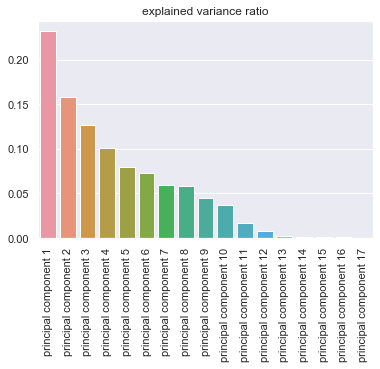

In [ ]:
barplot = sns.barplot(x=pca_label, y=pca.explained_variance_ratio_)
barplot.set_xticklabels(pca_label, rotation=90)
plt.title('explained variance ratio')
plt.show()

We can see that already the first three components together account for 50% of the total variance in the dataset. We can visualise this more systematically by plotting the cumulative sum of the explained variance rations:

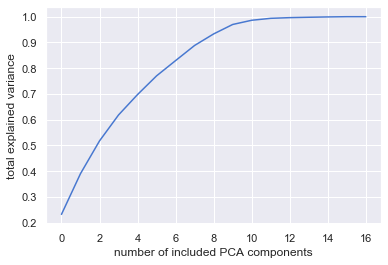

In [ ]:
sns.lineplot(np.arange(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('total explained variance')
plt.xlabel('number of included PCA components')
plt.show()

We see that with 7 of the 17 axis we already explain 90% percent of the variance in the dataset and that after 10 we almost reach 100%. That means the components 10-17 probably don't contain much information and can be discarded.

#### PCA vector composition
Naturally, we would like to know what these principal components mean. For example the first component contains 25% of the total variance. What information is stored in that component? The `pca` object also contains the `components_` which define the transformation between the original dataset and the transformed  one. We can print a few of the components and interpret them:

In [ ]:
def print_tabluar(labels, values):
    df = pd.DataFrame(data=values, columns=labels)
    display(df.T)

In [ ]:
print('The first three principal components:')
print_tabluar(feature_labels, pca.components_[:3])

The first three principal components:


,0,1,2
longitude,0.096240,-0.440492,0.279899
latitude,-0.093538,0.511034,-0.231581
housing_median_age,-0.228990,-0.102574,-0.203651
total_rooms,0.480823,0.110303,0.003569
total_bedrooms,0.481068,0.046098,-0.114091
population,0.466057,-0.002745,-0.121771
households,0.482901,0.023411,-0.149648
median_income,0.083829,0.066170,0.381905
rooms_per_household,0.029542,0.299368,0.519937
bedrooms_per_household,0.006354,0.204508,0.343374


The way to read this table is to think of it as a recipe to construct the first three principal components coordinates from the original features. Given a new datapoint we can for example calculate the first principal component by multiplying the longitude by the value in column `0` plus the latitude multiplied by the corresponding value in column `0` etc.. This weighted some of the original featuers will yield the first coordinate in the PCA coordinate system.

From this we can see that the first component mainly consists of the three features `total_rooms`, `total_bedrooms`, and `households`.

#### Visualisation
We can now use the principle components to visualise the data. We have a closer look at the first two components.

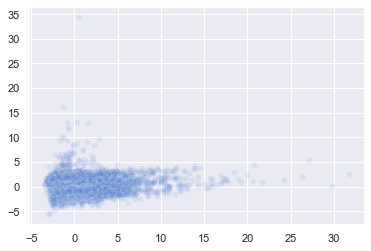

In [ ]:
sns.scatterplot(X_pca[:,0], X_pca[:,1], alpha=0.1)

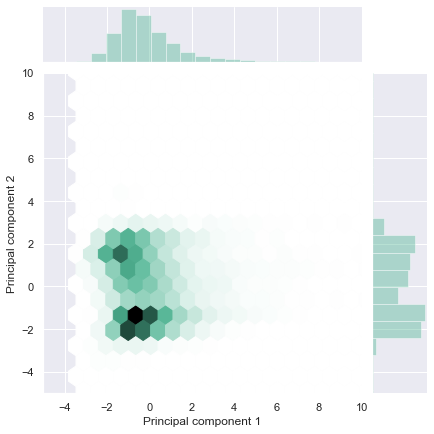

In [ ]:
jplot = sns.jointplot(X_pca[:,0],  X_pca[:,1], kind="hex", color="#4CB391",xlim=[-5,10], ylim=[-5,10])
jplot.set_axis_labels('Principal component 1', 'Principal component 2')

We observe that there seem to be two visible clusters along these two axis. We could now investigate these clusters further and might find some property of the dataset that might be useful to us or our customer.

#### Correlations
One interesting property to observe is that PCA removes all correlations from the features, such that each feature is independant.

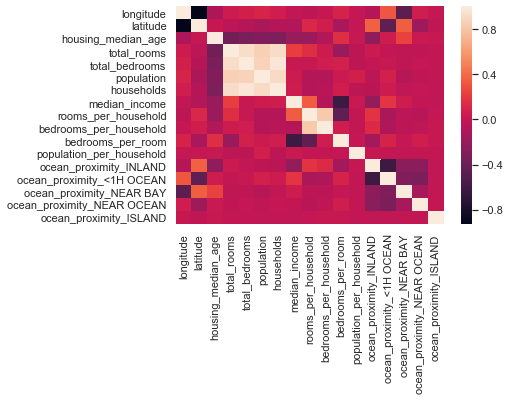

In [ ]:
sns.heatmap(pd.DataFrame(data=X_std, columns=feature_labels).corr())

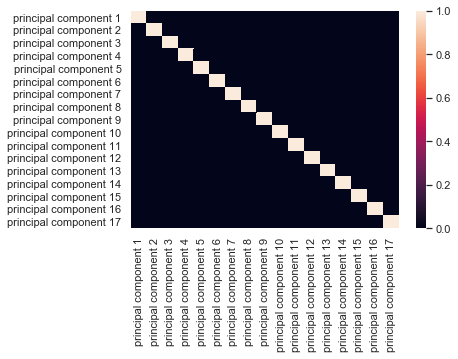

In [ ]:
sns.heatmap(pd.DataFrame(data=X_pca, columns=pca_label).corr())

#### Compressed model
Now we want to use PCA to build a model that is more compact than the model that utilizes all features. We add one principal component after the other and measure how well a Random Forest performs with this subset of features. We do this in our standard cross-validation loop.

In [ ]:
rmse_valid =[]
for i in tqdm(range(1, 18)):
    rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1, random_state=42)
                             
    results = cross_validate(rf, X_pca[:, :i], y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_valid.append(-np.mean(results["test_score"]))

100%|██████████| 17/17 [04:08<00:00, 14.61s/it]


As an additional baseline we also create a median regressor:

In [ ]:
rmse_median = rmse(y, [np.median(y)]*len(y))

Now we can plot the performances with the full Random Forest and the median regresssor as baselines for all subsets of components.

Text(0, 0.5, 'RMSE')

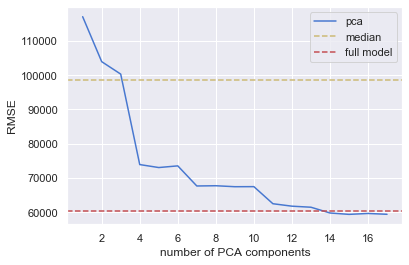

In [ ]:
lineplot = sns.lineplot(np.arange(len(rmse_valid))+1 , rmse_valid, label='pca')
lineplot.axhline(rmse_median, c='y', linestyle='--', label='median')
lineplot.axhline(rmse_full, c='r', linestyle='--', label='full model')
plt.legend(loc='best')
plt.xlabel('number of PCA components')
plt.ylabel('RMSE')

So we can see that already with 4-7 principal components we get results that are quite close to the full model. As mentioned previously this has two advantages:
1. Visualising a 4 components is still hard but feasable compared to 17
2. Training a Random forest with half the features is twice as fast for training and inference.

Looking at the graph we see that there are several steep steps. It seems that adding thses components improved the performance significantly. By taking the components with the biggest steps we can try to build a better selection of features:

In [ ]:
features = [0,1,3,6,10]

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1, random_state=42)
                             
results = cross_validate(rf, X_pca[:, features], y, cv=5,
                         return_train_score=True,
                         scoring='neg_root_mean_squared_error')
rmse_pca = -np.mean(results["test_score"])

In [ ]:
rmse_pca

64700.242256282574

Just with 5 of 17 features we get <10% of the model that used all features. This model is 3-4 times faster to train and to make predictions. In practice there are more systematic ways of finding the best subset of features such as *forward* and *backward selection*.

## Part 2: The mapper algorithm